Loading data...
Creating customer features...
Finding optimal number of clusters...


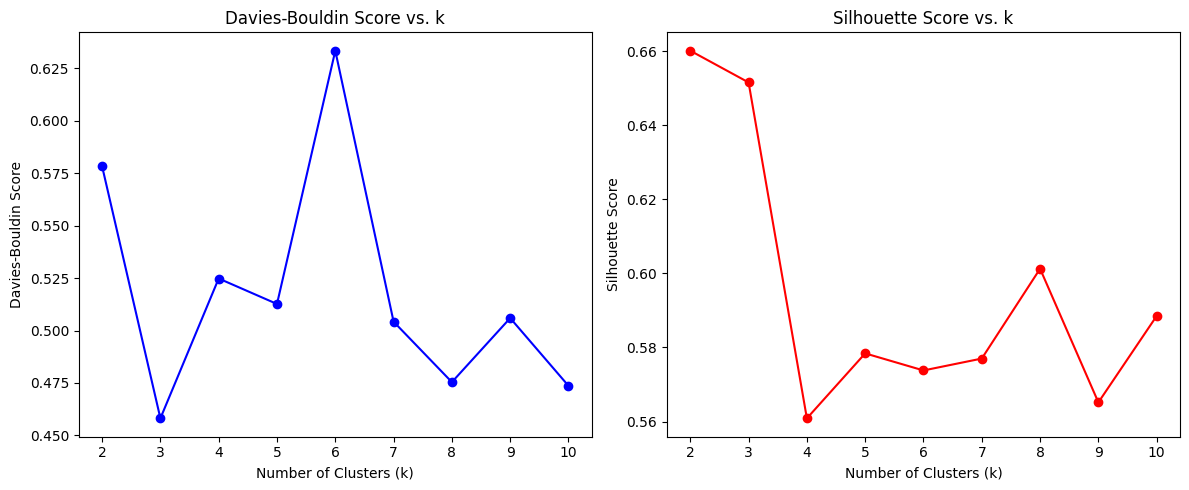

Optimal number of clusters: 3
Davies-Bouldin Score: 0.4581
Performing clustering...
Creating visualizations...


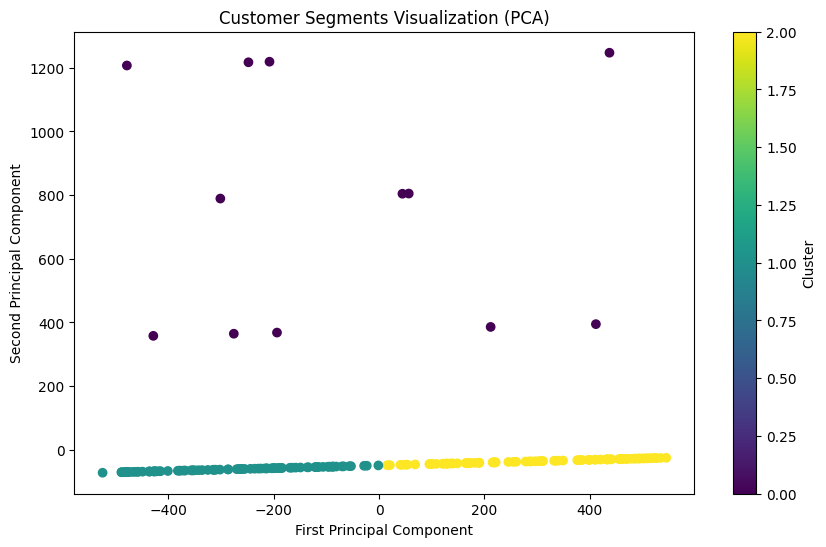

Analyzing clusters...
Saving results...
Done! Results saved to Jaffer_Ali_Clustering.txt


In [9]:
# Task 3: Customer Segmentation
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_prepare_data():
    # Load data
    customers_df = pd.read_csv('Customers.csv')

    # Create transactions DataFrame from the provided sample
    transactions_data = {
        'TransactionID': ['T00001', 'T00112', 'T00166', 'T00272', 'T00363', 'T00442', 'T00490',
                         'T00536', 'T00564', 'T00631', 'T00727', 'T00729'],
        'CustomerID': ['C0199', 'C0146', 'C0127', 'C0087', 'C0070', 'C0188', 'C0195',
                      'C0008', 'C0157', 'C0130', 'C0051', 'C0075'],
        'ProductID': ['P067']*12,
        'TransactionDate': ['25-08-2024 12:38', '27-05-2024 22:23', '25-04-2024 07:38',
                           '26-03-2024 22:55', '21-03-2024 15:10', '26-12-2024 14:40',
                           '24-11-2024 11:49', '22-09-2024 06:13', '07-12-2024 17:57',
                           '14-05-2024 23:14', '20-01-2024 04:52', '07-10-2024 06:38'],
        'Quantity': [1, 1, 1, 2, 3, 1, 3, 1, 3, 2, 3, 2],
        'TotalValue': [300.68, 300.68, 300.68, 601.36, 902.04, 300.68, 902.04,
                      300.68, 902.04, 601.36, 902.04, 601.36],
        'Price': [300.68]*12
    }
    transactions_df = pd.DataFrame(transactions_data)

    return customers_df, transactions_df

def create_customer_features(customers_df, transactions_df):
    # Create customer transaction features
    transaction_features = transactions_df.groupby('CustomerID').agg({
        'TransactionID': 'count',
        'Quantity': ['sum', 'mean'],
        'TotalValue': ['sum', 'mean']
    }).fillna(0)

    # Flatten column names
    transaction_features.columns = [
        'transaction_count',
        'total_quantity',
        'avg_quantity',
        'total_spend',
        'avg_spend'
    ]

    # Convert signup date to datetime
    customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])

    # Create customer age feature
    customers_df['days_since_signup'] = (pd.Timestamp('2024-01-27') - customers_df['SignupDate']).dt.days

    # Create final feature matrix
    customer_features = customers_df.set_index('CustomerID')

    # Add transaction features
    customer_features = customer_features.join(transaction_features)

    # Fill missing values
    customer_features = customer_features.fillna(0)

    # Convert region to dummy variables
    customer_features = pd.get_dummies(customer_features, columns=['Region'])

    return customer_features

def find_optimal_clusters(features, max_clusters=10):
    db_scores = []
    silhouette_scores = []
    K = range(2, max_clusters + 1)

    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(features)

        # Calculate Davies-Bouldin score
        db_score = davies_bouldin_score(features, kmeans.labels_)
        db_scores.append(db_score)

        # Calculate Silhouette score
        silhouette_avg = silhouette_score(features, kmeans.labels_)
        silhouette_scores.append(silhouette_avg)

    # Plot evaluation metrics
    plt.figure(figsize=(12, 5))

    plt.subplot(121)
    plt.plot(K, db_scores, 'bo-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Davies-Bouldin Score')
    plt.title('Davies-Bouldin Score vs. k')

    plt.subplot(122)
    plt.plot(K, silhouette_scores, 'ro-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs. k')

    plt.tight_layout()
    plt.show()

    # Return optimal k based on Davies-Bouldin score
    optimal_k = K[db_scores.index(min(db_scores))]
    return optimal_k, min(db_scores)

def perform_clustering(features, n_clusters):
    # Scale features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # Perform clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)

    return cluster_labels, kmeans.cluster_centers_

def visualize_clusters(features, labels):
    # Create PCA visualization
    from sklearn.decomposition import PCA

    # Apply PCA
    pca = PCA(n_components=2)
    features_2d = pca.fit_transform(features)

    # Create visualization
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='viridis')
    plt.title('Customer Segments Visualization (PCA)')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.colorbar(scatter, label='Cluster')
    plt.show()

def analyze_clusters(features, labels):
    # Add cluster labels to features
    features['Cluster'] = labels

    # Calculate cluster characteristics
    cluster_analysis = features.groupby('Cluster').agg({
        'total_spend': 'mean',
        'transaction_count': 'mean',
        'avg_quantity': 'mean',
        'days_since_signup': 'mean'
    }).round(2)

    return cluster_analysis

def main():
    # Load data
    print("Loading data...")
    customers_df, transactions_df = load_and_prepare_data()

    # Create customer features
    print("Creating customer features...")
    customer_features = create_customer_features(customers_df, transactions_df)

    # Select features for clustering
    clustering_features = customer_features.select_dtypes(include=['float64', 'int64'])

    # Find optimal number of clusters
    print("Finding optimal number of clusters...")
    optimal_k, db_score = find_optimal_clusters(clustering_features)
    print(f"Optimal number of clusters: {optimal_k}")
    print(f"Davies-Bouldin Score: {db_score:.4f}")

    # Perform clustering
    print("Performing clustering...")
    cluster_labels, cluster_centers = perform_clustering(clustering_features, optimal_k)

    # Visualize clusters
    print("Creating visualizations...")
    visualize_clusters(clustering_features, cluster_labels)

    # Analyze clusters
    print("Analyzing clusters...")
    cluster_analysis = analyze_clusters(customer_features, cluster_labels)

    # Save results
    print("Saving results...")
    with open('Jaffer_Ali_Clustering.txt', 'w') as f:
        f.write("Customer Segmentation Analysis Results\n")
        f.write("====================================\n\n")
        f.write(f"Number of clusters: {optimal_k}\n")
        f.write(f"Davies-Bouldin Index: {db_score:.4f}\n\n")
        f.write("Cluster Characteristics:\n")
        f.write(cluster_analysis.to_string())

    print("Done! Results saved to Jaffer_Ali_Clustering.txt")

if __name__ == "__main__":
    main()